## **1. Kaggle GPU configuration**

In Kaggle, you have 36 hours/week.

To enable GPU hardware accelerator, just **Select the Settings tab. Then select the checkbox for Enable GPU. Verify the GPU is attached to your kernel in the console bar, where it should show GPU ON next to your resource usage metrics**.

## **2. Requirements**

This notebook requires the following libraries, 
torch, torchvision, scikit-image, numpy, glob, tqdm, random, itertools, matplotlib. 

You can install them in Kaggle using **pip** like: 

!pip install torch torchvision

You can install all other needed packages using the methodology.

In [3]:
!pip install torch torchvision scikit-image numpy glob2 tqdm matplotlib tifffile imagecodecs

  Created wheel for glob2: filename=glob2-0.7-py2.py3-none-any.whl size=9321 sha256=2159bceeba6e07d074cadd4063c40db64b74acdc9492d6e50f4b20b750dedf4f
  Stored in directory: /root/.cache/pip/wheels/d7/3c/72/5300602ba1269ffce8cff5dcf7b525fee756b57455903c37ba
Successfully built glob2


## **3. Upload your dataset**

This example (UNet model) is trained on the ISPRS Potsdam dataset. We use the IRRG tiles (8bit format). Make sure that the Potsdam data is in your Kaggle input. Please see the figure below for more details
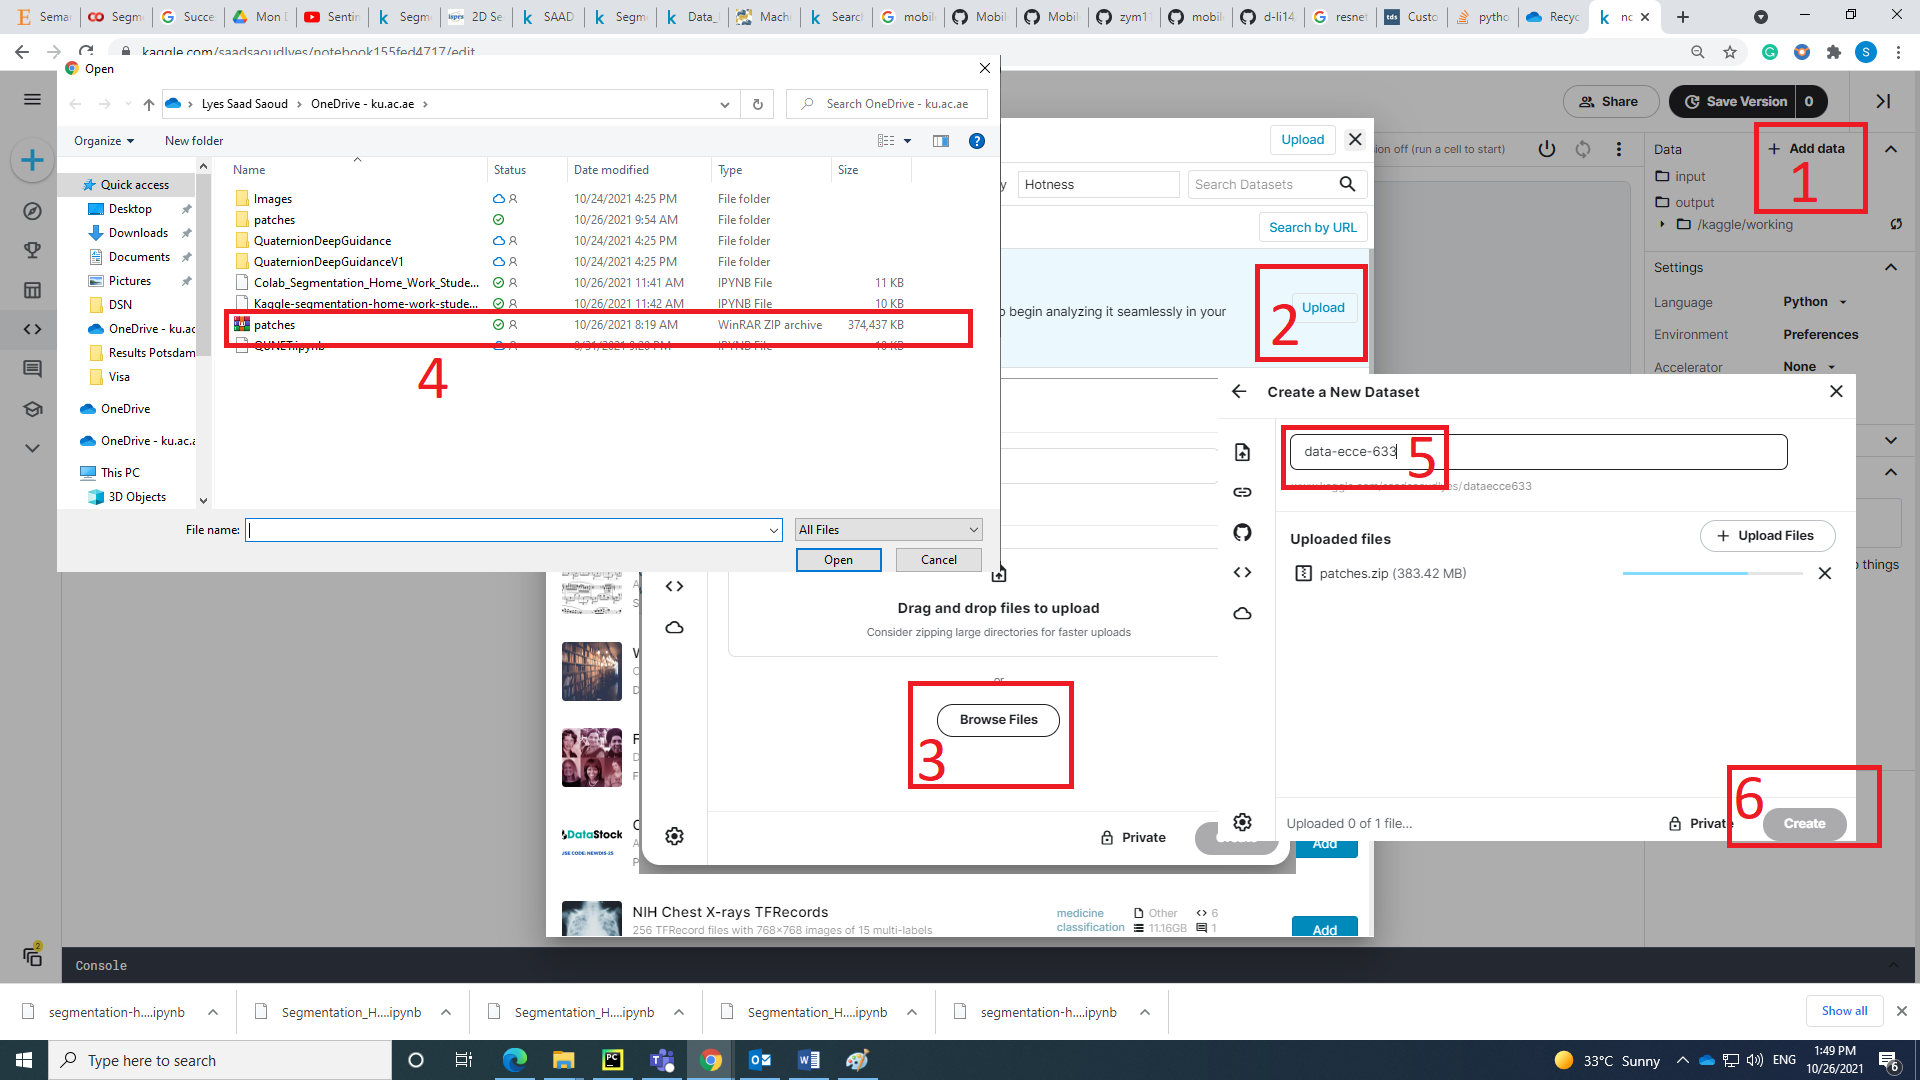
> # Please name the uploaded data like: data-ecce-633


## **4. Import the necessary packages:**
numpy, io, glob, tqdm_notebook, confusion_matrix, random, itertools, matplotlib.pyplot, torch, torch.nn,  torch.nn.functional, torch.utils.data, torch.optim, torch.optim.lr_scheduler, torch.nn.init

In [4]:
import numpy as np
from skimage import io
from glob import glob
from tqdm import tqdm_notebook as tqdm
from sklearn.metrics import confusion_matrix
import random
import itertools
import matplotlib.pyplot as plt
import shutil
# %matplotlib inline
# Torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable
import torchvision
import os
from IPython.display import clear_output
import tifffile as tiff 

In [5]:
import warnings
warnings.filterwarnings("ignore")

## **5. Initialization:**

In [6]:
# Parameters
IN_CHANNELS =  3                          # Number of input channels (e.g. RGB)
MAIN_FOLDER = "../input/segmentation/patches/"   # Your "/path/to/the/Images/folder/"
BATCH_SIZE = 10            # Number of samples in a mini-batch, example 10
LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS)                   # Number of classes
weights = torch.ones(N_CLASSES)           # Weights for class balancing
DATA_FOLDER = MAIN_FOLDER + 'Images/Image_{}.tif'
LABELS_FOLDER = MAIN_FOLDER + 'Labels/Label_{}.tif'

## **6. Functions you may need:**

In [7]:
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)
invert_palette = {v: k for k, v in palette.items()}
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """ '(From 0 to 6)'
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)
    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i
    return arr_2d


class Load_dataset(torch.utils.data.Dataset):
    def __init__(self, ids):
        super(Load_dataset, self).__init__()
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABELS_FOLDER.format(id) for id in ids]
        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
    def __len__(self):
        return len(self.data_files) # the length of the used data
    
    def __getitem__(self, idx):
#         Pre-processing steps
        #     # Data is normalized in [0, 1]
        self.data = 1/255 * np.asarray(io.imread(self.data_files[idx]).transpose((2,0,1)), dtype='float32')
        self.label = np.asarray(convert_from_color(io.imread(self.label_files[idx])), dtype='int64')
        data_p, label_p = self.data,  self.label
        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

    
    
def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0), input.size(1), -1)
        output = torch.transpose(output, 1, 2).contiguous()
        output = output.view(-1, output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target, weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))
 

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
        gts,
        predictions,
        range(len(label_values)))
    print("Confusion matrix :")
    print(cm)
    print("---")
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    return accuracy

# **7. Selecting training and testing data**

In [8]:
train_ids =list(range(0, 2000))
val_ids = list(range(2000,2200))
test_ids =  list(range(2200,2400))

In [9]:
trainset = Load_dataset(train_ids)
validationset = Load_dataset(val_ids)
testset = Load_dataset(test_ids)

In [10]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = torch.utils.data.DataLoader(validationset, batch_size=BATCH_SIZE)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE)

In [11]:
print(len(trainloader))
print(len(valloader))
print(len(testloader))

200
20
20


In [12]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

In [13]:
print(images.shape)
print(labels.shape)

torch.Size([10, 3, 300, 300])
torch.Size([10, 300, 300])


In [14]:
labels.dim()

3

# **8. Implement the Unet model**


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [16]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [17]:
for batch in trainloader:
    print(len(batch))
    print(batch[0].shape)
    print(batch[1].shape)
    break

2
torch.Size([10, 3, 300, 300])
torch.Size([10, 300, 300])


## Visualizing data

In [18]:
def convert_to_color(arr_2d, palette=palette):
    """ Encoding to RGB-color """
    n_channels = 3
    arr_3d = np.zeros((n_channels, arr_2d.shape[0], arr_2d.shape[1]))
    for c, i in palette.items():
#         print(arr_3d[:, c == arr_2d])
        arr_3d[0, arr_2d == c] = i[0]
        arr_3d[1, arr_2d == c] = i[1]
        arr_3d[2, arr_2d == c] = i[2]
    return arr_3d

In [19]:
def imshow(img):
    npimg = img.numpy()
    print(npimg.shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [20]:
def show_image_and_label(image, label, pred_label=None):
    if pred_label is None:
        rows = 1
        columns = 2
        fig = plt.figure(figsize=(10, 10))
        fig.add_subplot(rows, columns, 1)
        plt.title("Image")
        plt.imshow(np.asarray(image).transpose(1,2,0))
        fig.add_subplot(rows, columns, 2)
        plt.imshow(label.transpose(1,2,0))
        plt.title("Ground Truth")
    else:
        rows = 1
        columns = 3
        fig = plt.figure(figsize=(10, 15))
        fig.add_subplot(rows, columns, 1)
        plt.imshow(np.asarray(image).transpose(1,2,0))
        plt.title("Image")
        fig.add_subplot(rows, columns, 2)
        plt.imshow(label.transpose(1,2,0))
        plt.title("Ground Truth")
        fig.add_subplot(rows, columns, 3)
        plt.imshow(pred_label.transpose(1,2,0))
        plt.title("Predicted Label")

In [21]:
dataiter = iter(testloader)

(3, 1512, 606)


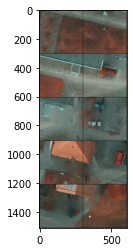

In [24]:
images, labels = dataiter.next()
# show images to select for proper visualization, search for proper image by re-running this cell
imshow(torchvision.utils.make_grid(images, nrow=2))

In [25]:
image_number = 5
label_image = convert_to_color(labels[image_number])

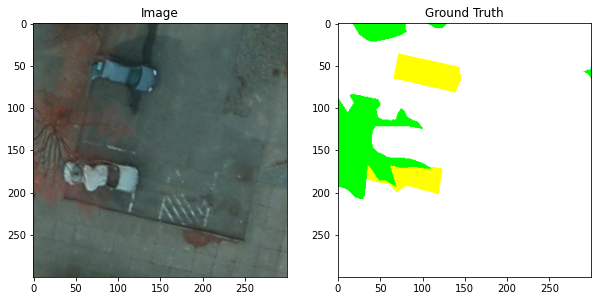

In [26]:
show_image_and_label(images[image_number], label_image)

# color Definition
* __white__ : Impervious surfaces 
* __blue__ : Buildings 
* __cyan__ : Low vegetation
* __green__ : Trees 
* __yellow__ : Cars 
* __red__ : Clutter 
* __black__ : Undefined 

### Testing the Model to check if its working fine and checking the result without any training so that we can conclude later that after training the model is actually converging towards required result

In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))

# train loader 
dataiter = iter(trainloader)
images, labels = next(dataiter)

# UNET Model
net = UNet(n_channels=3, n_classes=6, bilinear=True)

net.to(device=device) # transferring to GPU

images = images.to(device=device, dtype=torch.float32)
labels = labels.to(device=device)
output_pred = net(images)

Using cuda


In [28]:
print(labels.shape)
print(output_pred.shape)

torch.Size([10, 300, 300])
torch.Size([10, 6, 300, 300])


In [29]:
output_pred.dim()

4

In [30]:
CrossEntropy2d(output_pred, labels)

tensor(1.8572, device='cuda:0', grad_fn=<NllLossBackward>)

In [31]:
output_pred_cpu = output_pred.cpu().detach().numpy() 
labels_cpu = labels.cpu().detach().numpy()

In [32]:
print(output_pred_cpu.shape)
print(labels_cpu.shape)

(10, 6, 300, 300)
(10, 300, 300)


In [33]:
output_pred_cpu[0, :].shape

(6, 300, 300)

In [34]:
np.argmax(output_pred_cpu, axis=1).shape

(10, 300, 300)

In [35]:
np.argmax(output_pred_cpu, axis=1)[0]

array([[4, 3, 1, ..., 3, 2, 3],
       [4, 4, 1, ..., 1, 1, 4],
       [4, 1, 1, ..., 1, 1, 4],
       ...,
       [1, 4, 1, ..., 0, 0, 2],
       [4, 4, 4, ..., 3, 4, 0],
       [1, 1, 1, ..., 4, 4, 4]])

In [36]:
labels_cpu[0]

array([[1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 2, 0],
       [1, 1, 1, ..., 1, 0, 0],
       [1, 1, 1, ..., 1, 1, 0]])

In [37]:
# This is being tested because the confusion matrix from scikit learn 
# requires 1S array for developing confusion matrix
print(np.argmax(output_pred_cpu, axis=1).flatten().shape)
print(labels_cpu.flatten().shape)

(900000,)
(900000,)


In [38]:
random_acc = metrics(np.argmax(output_pred_cpu, axis=1).flatten(), labels_cpu.flatten(), label_values=LABELS)

Confusion matrix :
[[ 27966  73718   2520  15335  58312   3015]
 [ 23792  65728   3591  24520 120103  20905]
 [  4008  75059   1472  22543 100068   1552]
 [   378  14862    237   3495  16411   4062]
 [   473   2704    161   1166   2908    366]
 [  8676  61197   4365  21581  98788  13963]]
---
900000 pixels processed
Total accuracy : 12.83688888888889%


### We can see that accuracy of the initial untrained current model is just 12.83%

### Lets visualize the untrained model result

In [39]:
np.argmax(output_pred_cpu, axis=1)[0].shape

(300, 300)

Prediction from model of accuracy 12.84


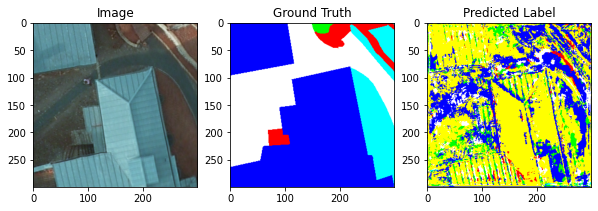

In [40]:
# Since the data are usually in GPU so they need to be detached before we can plot them

# Some Random prediction data sample 1
image_number = 0
print("Prediction from model of accuracy %0.2f"%random_acc)
color_label = convert_to_color(labels[image_number].cpu().detach().numpy())
pred_color_label = convert_to_color(np.argmax(output_pred_cpu, axis=1)[image_number])
show_image_and_label(images[image_number].cpu().detach().numpy(), color_label, pred_color_label)

Prediction from model of accuracy 12.84


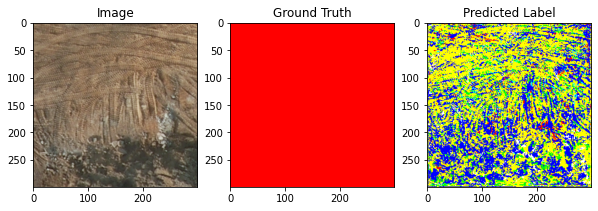

In [41]:
# Some Random prediction data sample 2
image_number = 1
print("Prediction from model of accuracy %0.2f"%random_acc)
color_label = convert_to_color(labels[image_number].cpu().detach().numpy())
pred_color_label = convert_to_color(np.argmax(output_pred_cpu, axis=1)[image_number])
show_image_and_label(images[image_number].cpu().detach().numpy(), color_label, pred_color_label)

Prediction from model of accuracy 12.84


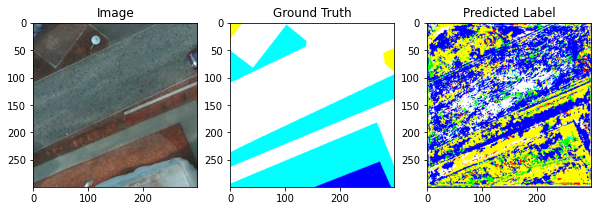

In [42]:
# Some Random prediction data sample 3
image_number = 2
print("Prediction from model of accuracy %0.2f"%random_acc)
color_label = convert_to_color(labels[image_number].cpu().detach().numpy())
pred_color_label = convert_to_color(np.argmax(output_pred_cpu, axis=1)[image_number])
show_image_and_label(images[image_number].cpu().detach().numpy(), color_label, pred_color_label)

In [44]:
# Redefing the metrics by commenting the printing of confusion matrix 
# SO that it does not keep on printing during training
def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(gts, predictions, range(len(label_values)))
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)

    return accuracy

# **9.Training:**

In [47]:
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        print("Saving best model !")
        shutil.copyfile(filename, 'model_best.pth.tar')

In [51]:
epochs = 20
learning_rate = 0.001
n_train = len(trainloader)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {} ".format(device))
# Change here to adapt to your data
# n_channels=3 for RGB images
# n_classes is the number of probabilities you want to get per pixel
net = UNet(n_channels=3, n_classes=6, bilinear=True)

Using cuda 


In [52]:
net.to(device=device)
optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)
criterion = nn.CrossEntropyLoss()
print_every = 100

# 5. Begin training
train_loss_array = []
val_loss_array = []
val_acc_array = []
best_acc1 = 0
for epoch in range(epochs):
    net.train()
    train_loss = 0
    i = 0
    for batch in trainloader:
        i += 1
        optimizer.zero_grad()
        images = batch[0]
        true_masks = batch[1]

        assert images.shape[1] == net.n_channels, f'Network has been defined with {net.n_channels} input channels, ' f'but loaded images have {images.shape[1]} channels. Please check that the images are loaded correctly.'

        images = images.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device)


        masks_pred = net(images)

        loss = CrossEntropy2d(masks_pred, true_masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        
        # Testing the model performance on Validation set on every 100 loop through training batch
        if i % print_every == 0:
            train_loss_array.append(train_loss/print_every)
            masks_pred_cpu = masks_pred.cpu().detach().numpy() 
            true_masks_cpu = true_masks.cpu().detach().numpy()
            print('[%d epoch, %5d batch] Train loss: %.3f Train accuracy : %.3f' % (epoch + 1, i, train_loss / print_every, metrics(np.argmax(masks_pred_cpu, axis=1).flatten(), true_masks_cpu.flatten(), label_values=LABELS)))
            train_loss = 0.0
            
            # Validation data 
            val_loss = 0.0
            val_accuracy = 0.0
            n_val = len(valloader)
            with torch.no_grad():
                net.eval()
                for data in valloader:
                    images = data[0]
                    true_masks = data[1]
                    images = images.to(device=device, dtype=torch.float32)
                    true_masks = true_masks.to(device=device)
                    
                    # Making prediction
                    masks_pred = net(images)
                    val_batch_loss = CrossEntropy2d(masks_pred, true_masks)
                    val_loss += val_batch_loss.item()
                    
                    masks_pred_cpu = masks_pred.cpu().detach().numpy() 
                    true_masks_cpu = true_masks.cpu().detach().numpy()
                    val_accuracy += metrics(np.argmax(masks_pred_cpu, axis=1).flatten(), true_masks_cpu.flatten(), label_values=LABELS)
                val_loss_array.append(val_loss/n_val)
                val_acc_array.append(val_accuracy/n_val)
                print("Val loss: %.3f Val accuracy : %.3f"%(val_loss/n_val, val_accuracy/n_val))
                
                acc1 = val_accuracy/n_val
                is_best = acc1 > best_acc1
                best_acc1 = max(acc1, best_acc1)
                save_checkpoint({
                    'epoch': epoch + 1,
                    'state_dict': net.state_dict(),
                    'best_acc1': best_acc1,
                    'optimizer' : optimizer.state_dict(),
                }, is_best)
                print("******************************************")
        net.train()


print("Finish Training")

[1 epoch,   100 batch] Train loss: 1.284 Train accuracy : 54.413
Val loss: 1.199 Val accuracy : 44.073
Saving best model !
******************************************
[1 epoch,   200 batch] Train loss: 1.156 Train accuracy : 51.017
Val loss: 1.202 Val accuracy : 50.357
Saving best model !
******************************************
[2 epoch,   100 batch] Train loss: 1.091 Train accuracy : 55.898
Val loss: 1.298 Val accuracy : 39.358
******************************************
[2 epoch,   200 batch] Train loss: 1.054 Train accuracy : 48.535
Val loss: 0.981 Val accuracy : 61.646
Saving best model !
******************************************
[3 epoch,   100 batch] Train loss: 1.010 Train accuracy : 58.542
Val loss: 0.948 Val accuracy : 65.042
Saving best model !
******************************************
[3 epoch,   200 batch] Train loss: 1.021 Train accuracy : 65.487
Val loss: 0.933 Val accuracy : 68.053
Saving best model !
******************************************
[4 epoch,   100 batch] T

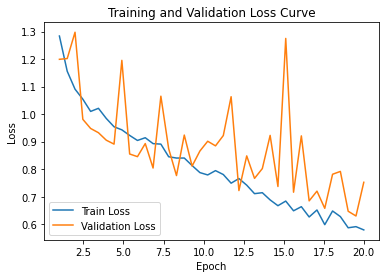

In [53]:
epoch_array = np.linspace(1, epochs, len(train_loss_array))
plt.plot(epoch_array, train_loss_array, label = "Train Loss")
plt.plot(epoch_array, val_loss_array, label = "Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
# Display a figure.
plt.show()

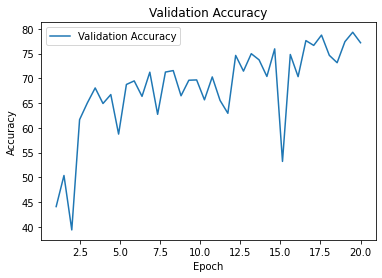

In [54]:
plt.plot(epoch_array, val_acc_array, label = "Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
# Display a figure.
plt.show()

# **10. Testing:**

In [55]:
!ls

__notebook_source__.ipynb  checkpoint.pth.tar  model_best.pth.tar


In [61]:
# Best validation accuracy Unet Model
PATH = 'model_best.pth.tar'
state = torch.load(PATH)

net = UNet(n_channels=3, n_classes=6, bilinear=True)
net.load_state_dict(state['state_dict'])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using {}".format(device))
net = net.to(device=device)

Using cuda


In [62]:
test_loss = 0.0
test_accuracy = 0.0
n_test = len(testloader)
with torch.no_grad():
    net.eval()
    for data in testloader:
        images = data[0]
        true_masks = data[1]
        images = images.to(device=device, dtype=torch.float32)
        true_masks = true_masks.to(device=device)

        masks_pred = net(images)
        loss = CrossEntropy2d(masks_pred, true_masks)
        test_loss += loss.item()

        masks_pred_cpu = masks_pred.cpu().detach().numpy() 
        true_masks_cpu = true_masks.cpu().detach().numpy()
        test_accuracy += metrics(np.argmax(masks_pred_cpu, axis=1).flatten(), true_masks_cpu.flatten(), label_values=LABELS)

In [63]:
# 20 epoch result
print("Test Loss = {}".format(test_loss/n_test))
print("Test Accuracy = {}".format(test_accuracy/n_test))

Test Loss = 0.5495890513062477
Test Accuracy = 79.9924


## Generating some prediction results

In [64]:
# train loader 
dataiter = iter(testloader)

In [79]:
images, labels = next(dataiter)

# UNET Model
with torch.no_grad():
    net.eval()
    net.to(device=device) # transferring to GPU

    images = images.to(device=device, dtype=torch.float32)
    labels = labels.to(device=device)
    output_pred = net(images)

In [80]:
output_pred_cpu = output_pred.cpu().detach().numpy() 
labels_cpu = labels.cpu().detach().numpy()

Prediction from model of accuracy 79.31


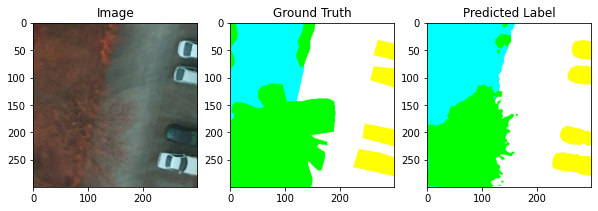

In [81]:
# Model prediction on data sample 1
image_number = 0
print("Prediction from model of accuracy %0.2f"%state['best_acc1'])
color_label = convert_to_color(labels[image_number].cpu().detach().numpy())
pred_color_label = convert_to_color(np.argmax(output_pred_cpu, axis=1)[image_number])
show_image_and_label(images[image_number].cpu().detach().numpy(), color_label, pred_color_label)

Prediction from model of accuracy 79.31


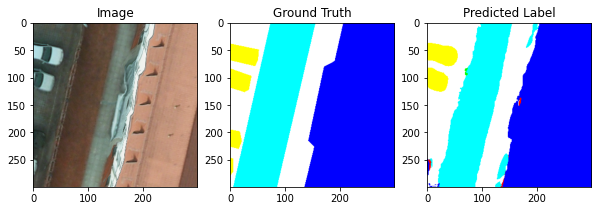

In [82]:
# Model prediction on data sample 2
image_number = 1
print("Prediction from model of accuracy %0.2f"%state['best_acc1'])
color_label = convert_to_color(labels[image_number].cpu().detach().numpy())
pred_color_label = convert_to_color(np.argmax(output_pred_cpu, axis=1)[image_number])
show_image_and_label(images[image_number].cpu().detach().numpy(), color_label, pred_color_label)

Prediction from model of accuracy 79.31


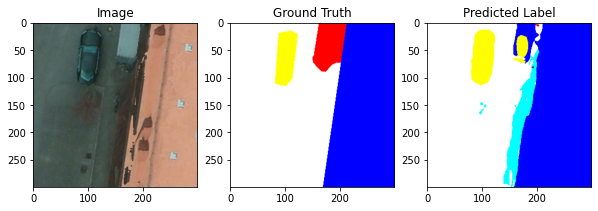

In [83]:
# Model prediction data sample 3
image_number = 3
print("Prediction from model of accuracy %0.2f"%state['best_acc1'])
color_label = convert_to_color(labels[image_number].cpu().detach().numpy())
pred_color_label = convert_to_color(np.argmax(output_pred_cpu, axis=1)[image_number])
show_image_and_label(images[image_number].cpu().detach().numpy(), color_label, pred_color_label)